In [ ]:
import random as pyrandom
from sage.all import *

# ============================================================
#   Helper: all simple paths + subpath number
# ============================================================

def all_simple_paths(G, start, end, visited=None):
    if visited is None:
        visited = []
    visited = visited + [start]
    if start == end:
        return [visited]
    paths = []
    for nei in G.neighbors(start):
        if nei not in visited:
            newp = all_simple_paths(G, nei, end, visited)
            paths.extend(newp)
    return paths

def subpath_number(G):
    V = G.vertices()
    total = 0
    for i in range(len(V)):
        for j in range(i, len(V)):
            total += len(all_simple_paths(G, V[i], V[j]))
    return total

# ============================================================
#   Mutacija grafa
# ============================================================

def mutate_graph(G):
    H = G.copy()

    edges = list(H.edges())
    non_edges = [(u, v) for u in H.vertices()
                 for v in H.vertices()
                 if u < v and not H.has_edge(u, v)]

    if not edges or not non_edges:
        return H

    e_remove = pyrandom.choice(edges)
    H.delete_edge(e_remove)

    e_add = pyrandom.choice(non_edges)
    H.add_edge(e_add)

    if not H.is_connected():
        return G

    return H

# ============================================================
#   Naključni povezan graf G(n, m)
# ============================================================
def random_connected_graph(n, m):
    while True:
        G = graphs.RandomGNM(n, m)
        if G.is_connected():
            return G

# ============================================================
#   Preverjanje PTC
# ============================================================
def is_ptc(G):
    # mora biti povezan
    if not G.is_connected():
        return False

    # blok-komponente in presečišča
    blocks, cut_vertices = G.blocks_and_cut_vertices()

    # shranimo samo nenetrivialne bloke (vsaj 2 vozlišči)
    nontrivial_blocks = [Bl for Bl in blocks if len(Bl) >= 2]
    B = len(nontrivial_blocks)

    if B < 2:
        return False

    # 1) vsak nenetrivialen blok mora biti trikotnik (C3)
    triangular_idx = []
    for i, Bl in enumerate(nontrivial_blocks):
        sub = G.subgraph(Bl)
        if sub.order() == 3 and sub.size() == 3:
            triangular_idx.append(i)
        else:
            # če je kakšen blok, ki ni trikotnik, ni PTC
            return False

    k = len(triangular_idx)
    if k < 2:
        return False

    # 2) zgradimo block-graf med trikotniki
    adj = {i: [] for i in triangular_idx}

    for i in triangular_idx:
        for j in triangular_idx:
            if j <= i:
                continue
            inter = set(nontrivial_blocks[i]).intersection(nontrivial_blocks[j])
            if len(inter) > 1:
                # dva trikotnika ne smeta deliti več kot enega vozlišča
                return False
            if len(inter) == 1:
                adj[i].append(j)
                adj[j].append(i)

    # 3) preverimo, da je block-graf pot: stopnje ≤2,
    #    točno dva trikotnika stopnje 1, ostali stopnje 2
    degrees = [len(adj[i]) for i in triangular_idx]

    if any(d == 0 or d > 2 for d in degrees):
        return False

    ends = sum(1 for d in degrees if d == 1)
    mids = sum(1 for d in degrees if d == 2)

    if ends != 2:
        return False
    if ends + mids != k:
        return False

    # 4) preverimo še povezavnost med trikotniki (da je res ena sama veriga)
    # BFS po block-grafu
    start = triangular_idx[0]
    visited = set([start])
    stack = [start]

    while stack:
        v = stack.pop()
        for w in adj[v]:
            if w not in visited:
                visited.add(w)
                stack.append(w)

    if len(visited) != k:
        return False

    return True


# ============================================================
#   Simulated annealing + STOP WHEN PTC FOUND
# ============================================================

def simulated_annealing(n, m, direction,
                        T_start=25.0, T_end=0.001,
                        cooling=0.9995, max_steps=4000):

    # začetni graf
    G = random_connected_graph(n, m)

    best_G = G.copy()
    best_score = subpath_number(G)

    current_G = G.copy()
    current_score = best_score

    T = T_start

    for step in range(max_steps):

        new_G = mutate_graph(current_G)
        new_score = subpath_number(new_G)

        # izračun delte
        if direction == "min":
            delta = new_score - current_score
        else:  # direction == "max"
            delta = current_score - new_score

        # SA sprejem
        if delta < 0:
            current_G = new_G
            current_score = new_score
        else:
            if pyrandom.random() < exp(-delta / T):
                current_G = new_G
                current_score = new_score

        # ===========================
        #   PREVERJANJE IZBOLJŠAVE
        # ===========================
        improved = False

        if direction == "min":
            if current_score < best_score:
                improved = True
        else: # direction == "max"
            if current_score > best_score:
                improved = True

        if improved:
            best_score = current_score
            best_G = current_G.copy()

            print(f"Improved at step {step}: best = {best_score}")
            best_G.show()

            # -------------------------------
            #   PTC STOP CONDITION (MIN ONLY)
            # -------------------------------
            if direction == "min" and is_ptc(best_G):
                print("PTC FOUND → stopping SA early!")
                return best_G, best_score

        # hlajenje
        T *= cooling
        if T < T_end:
            break

    return best_G, best_score

# ============================================================
#   TEST
# ============================================================

n = 9
c = 5
m = c + n - 1
direction = "min"

best_graph, best_value = simulated_annealing(n, m, direction)
print("Best:", best_value)
best_graph.show()



In [ ]:
# kle je isto samo da je zanka po stevilu povezav
import random as pyrandom
from sage.all import *

# ============================================================
#   Helper: all simple paths + subpath number
# ============================================================

def all_simple_paths(G, start, end, visited=None):
    if visited is None:
        visited = []
    visited = visited + [start]
    if start == end:
        return [visited]
    paths = []
    for nei in G.neighbors(start):
        if nei not in visited:
            newp = all_simple_paths(G, nei, end, visited)
            paths.extend(newp)
    return paths

def subpath_number(G):
    V = G.vertices()
    total = 0
    for i in range(len(V)):
        for j in range(i, len(V)):
            total += len(all_simple_paths(G, V[i], V[j]))
    return total


# ============================================================
#   Mutacija grafa
# ============================================================

def mutate_graph(G):
    H = G.copy()

    edges = list(H.edges())
    non_edges = [(u, v) for u in H.vertices()
                 for v in H.vertices()
                 if u < v and not H.has_edge(u, v)]

    if not edges or not non_edges:
        return H

    e_remove = pyrandom.choice(edges)
    H.delete_edge(e_remove)

    e_add = pyrandom.choice(non_edges)
    H.add_edge(e_add)

    if not H.is_connected():
        return G

    return H


# ============================================================
#   Naključni povezan graf G(n, m)
# ============================================================

def random_connected_graph(n, m):
    while True:
        G = graphs.RandomGNM(n, m)
        if G.is_connected():
            return G


# ============================================================
#   Preverjanje PTC
# ============================================================

def is_ptc(G):
    if not G.is_connected():
        return False

    blocks, cut_vertices = G.blocks_and_cut_vertices()
    nontrivial = [Bl for Bl in blocks if len(Bl) >= 2]

    if len(nontrivial) < 2:
        return False

    # vsi nenetrivialni bloki morajo biti trikotniki
    for Bl in nontrivial:
        sub = G.subgraph(Bl)
        if not (sub.order() == 3 and sub.size() == 3):
            return False

    idx = list(range(len(nontrivial)))
    adj = {i: [] for i in idx}

    # povezave med trikotniki
    for i in idx:
        for j in idx:
            if j <= i:
                continue
            inter = set(nontrivial[i]).intersection(nontrivial[j])
            if len(inter) > 1:
                return False
            if len(inter) == 1:
                adj[i].append(j)
                adj[j].append(i)

    deg = [len(adj[i]) for i in idx]

    if any(d == 0 or d > 2 for d in deg):
        return False

    ends = sum(1 for d in deg if d == 1)
    mids = sum(1 for d in deg if d == 2)

    if ends != 2:
        return False
    if ends + mids != len(idx):
        return False

    # preveri povezavnost verige trikotnikov
    start = idx[0]
    visited = {start}
    stack = [start]

    while stack:
        v = stack.pop()
        for w in adj[v]:
            if w not in visited:
                visited.add(w)
                stack.append(w)

    return len(visited) == len(idx)


# ============================================================
#   Simulated annealing (BREZ izrisovanja vmesnih izboljšav)
# ============================================================

def simulated_annealing(n, m, direction,
                        T_start=5.0, T_end=0.01,
                        cooling=0.999, max_steps=5000):

    G = random_connected_graph(n, m)

    best_G = G.copy()
    best_score = subpath_number(G)

    current_G = G.copy()
    current_score = best_score

    T = T_start

    for step in range(max_steps):

        new_G = mutate_graph(current_G)
        new_score = subpath_number(new_G)

        if direction == "min":
            delta = new_score - current_score
        else:
            delta = current_score - new_score

        if delta < 0:
            current_G, current_score = new_G, new_score
        else:
            if pyrandom.random() < exp(-delta / T):
                current_G, current_score = new_G, new_score

        # preveri izboljšavo
        improved = (
            (direction == "min" and current_score < best_score) or
            (direction == "max" and current_score > best_score)
        )

        if improved:
            best_score = current_score
            best_G = current_G.copy()

        T *= cooling
        if T < T_end:
            break

    return best_G, best_score


# ============================================================
#   ZANKA PO INTERVALU m
# ============================================================

n = 8
m_start = 11
m_end   = 16
direction = "min"   # ali "max"

results = []

for m in range(m_start, m_end + 1):
    print(f"\n=== n={n}, m={m} ===")
    best_graph, best_value = simulated_annealing(n, m, direction)
    print(f"Optimalni p_n(G) = {best_value}")
    results.append((m, best_value, best_graph))


# ------------------------------------------------------------
#   Če želiš izrisati samo končne grafe:
# ------------------------------------------------------------

for m, val, G in results:
    print(f"\nKončni graf za m={m}, p_n(G)={val}")
    G.show()


In [ ]:
import random as pyrandom
from sage.all import *
import pandas as pd

# ============================================================
#   Subpath number
# ============================================================

def all_simple_paths(G, start, end, visited=None):
    if visited is None:
        visited = []
    visited = visited + [start]
    if start == end:
        return [visited]
    paths = []
    for nei in G.neighbors(start):
        if nei not in visited:
            newp = all_simple_paths(G, nei, end, visited)
            paths.extend(newp)
    return paths


def subpath_number(G):
    V = G.vertices()
    total = 0
    for i in range(len(V)):
        for j in range(i, len(V)):
            total += len(all_simple_paths(G, V[i], V[j]))
    return total


# ============================================================
#   Mutacija grafa
# ============================================================

def mutate_graph(G):
    H = G.copy()

    edges = list(H.edges())
    non_edges = [(u, v) for u in H.vertices()
                 for v in H.vertices()
                 if u < v and not H.has_edge(u, v)]

    if not edges or not non_edges:
        return H

    e_remove = pyrandom.choice(edges)
    H.delete_edge(e_remove)

    e_add = pyrandom.choice(non_edges)
    H.add_edge(e_add)

    if not H.is_connected():
        return G

    return H


# ============================================================
#   Expand graph (from n-1 to n)
# ============================================================

def expand_graph(G_old, n_new, m_target, direction):
    """
    Razširi graf G_old (z n-1 vozlišči) na graf z n vozlišči in m_target robovi.
    """
    H = Graph(G_old)

    # novo vozlišče naj ima label = max+1 (ne zaupamo n_new)
    new_v = max(H.vertices()) + 1
    H.add_vertex(new_v)

    # osnovna povezava za povezanost
    H.add_edge(0, new_v)

    while H.size() < m_target:

        if direction == "min":
            # minimalna invazivnost: najprej povezuj new_v z različnimi vozlišči
            for v in H.vertices():
                if v != new_v and not H.has_edge(v, new_v):
                    H.add_edge(v, new_v)
                    break
            # če še manjka, dodaj poljuben ne-rob
            if H.size() < m_target:
                for u in H.vertices():
                    for v in H.vertices():
                        if u < v and not H.has_edge(u, v):
                            H.add_edge(u, v)
                            break
                    if H.size() == m_target:
                        break

        else:
            # maksimalna invazivnost: new_v močno poveži
            for v in H.vertices():
                if v != new_v and not H.has_edge(new_v, v):
                    H.add_edge(new_v, v)
                    break
            if H.size() < m_target:
                for u in H.vertices():
                    for v in H.vertices():
                        if u < v and not H.has_edge(u, v):
                            H.add_edge(u, v)
                            break
                    if H.size() == m_target:
                        break

    return H

#########################################

def load_optimal_graph_flexible(n_old, mu_desired, direction):
    """
    Vrne optimalni graf za dano (n_old, µ), pri µ izbere najbližji ali največji možen.
    Nikoli ne vrže KeyError – vedno jasno pove, kaj manjka.
    """

    # Dodaj encoding za pravilno branje µ znaka
    df = pd.read_csv("rezultati_subpath_grafi_enolicni.csv", encoding='utf-8')

    n_old = int(n_old)
    mu_desired = int(mu_desired)

    # 1) Filtriraj samo grafi z danim n_old
    subset = df[df["n"] == n_old]

    if subset.empty:
        raise ValueError(f"V CSV ni nobene vrstice za n={n_old}")

    # 2) Katere µ vrednosti sploh obstajajo?
    available_mu = sorted(int(x) for x in subset["µ(G)"].unique())

    # 3) izberi µ_old
    if mu_desired in available_mu:
        mu_old = mu_desired
    else:
        mu_old = max(available_mu)

    # 4) Izberi vrstico s tem µ
    row = subset[subset["µ(G)"] == mu_old]

    if row.empty:
        raise ValueError(f"Za n={n_old} obstaja µ vrednosti {available_mu}, ne pa µ={mu_old}")

    # 5) Ker je row še vedno DataFrame, pretvori v Series
    # POMEMBNO: uporabi Python int(), ne SageMath Integer
    row = row.iloc[int(0)]  # ali preprosto: row.iloc[0]

    # 6) Izberi graph6 zapis
    if direction == "min":
        g6 = str(row["graph6_min"]).strip()
    else:
        g6 = str(row["graph6_max"]).strip()

    # 7) Ustvari graf
    return Graph(g6)



# ============================================================
#   Simulated annealing WITH advanced initialization
# ============================================================
def simulated_annealing(n, m, direction,
                        T_start=25.0, T_end=0.001,
                        cooling=0.9995, max_steps=4000):

    n = int(n)
    m = int(m)
    mu = m - n + 1

    # začetni graf iz n-1 optimumov
    if mu >= 1:
        G_old = load_optimal_graph_flexible(n_old=n-1,
                                            mu_desired=mu+1,
                                            direction=direction)
    else:
        # mu = 0 → drevo; vzemi μ_old = 1 ali največji razpoložljivi
        G_old = load_optimal_graph_flexible(n_old=n-1,
                                            mu_desired=1,
                                            direction=direction)

    G = expand_graph(G_old, n_new=n, m_target=m, direction=direction)

    best_G = G.copy()
    best_score = subpath_number(G)

    current_G = G.copy()
    current_score = best_score

    T = T_start

    for step in range(max_steps):
        new_G = mutate_graph(current_G)
        new_score = subpath_number(new_G)

        if direction == "min":
            delta = new_score - current_score
        else:
            delta = current_score - new_score

        if delta < 0:
            current_G = new_G
            current_score = new_score
        else:
            if pyrandom.random() < exp(-delta/T):
                current_G = new_G
                current_score = new_score

        improved = ((direction == "min" and current_score < best_score) or
                    (direction == "max" and current_score > best_score))

        if improved:
            best_G = current_G.copy()
            best_score = current_score

            if direction == "min":
                return best_G, best_score

        T *= cooling
        if T < T_end:
            break

    return best_G, best_score



# ============================================================
#   EXAMPLE RUN
# ============================================================

n = 9
m = 10   # μ = m - n + 1 = 0
direction = "min"

best_graph, best_value = simulated_annealing(n, m, direction)

print("Best value:", best_value)
best_graph.show()
print("graph6:", best_graph.graph6_string())


Kle poskusam zdej se zapisovati v CSV

In [ ]:

import random as pyrandom
from sage.all import *
import pandas as pd

# ============================================================
#   Subpath number
# ============================================================

def all_simple_paths(G, start, end, visited=None):
    if visited is None:
        visited = []
    visited = visited + [start]
    if start == end:
        return [visited]
    paths = []
    for nei in G.neighbors(start):
        if nei not in visited:
            newp = all_simple_paths(G, nei, end, visited)
            paths.extend(newp)
    return paths


def subpath_number(G):
    V = G.vertices()
    total = 0
    for i in range(len(V)):
        for j in range(i, len(V)):
            total += len(all_simple_paths(G, V[i], V[j]))
    return total


# ============================================================
#   Mutacija grafa
# ============================================================

def mutate_graph(G):
    H = G.copy()

    edges = list(H.edges())
    non_edges = [(u, v) for u in H.vertices()
                 for v in H.vertices()
                 if u < v and not H.has_edge(u, v)]

    if not edges or not non_edges:
        return H

    e_remove = pyrandom.choice(edges)
    H.delete_edge(e_remove)

    e_add = pyrandom.choice(non_edges)
    H.add_edge(e_add)

    if not H.is_connected():
        return G

    return H


# ============================================================
#   Expand graph (from n-1 to n)
# ============================================================

def expand_graph(G_old, n_new, m_target, direction):
    """
    Razširi graf G_old (z n-1 vozlišči) na graf z n vozlišči in m_target robovi.
    """
    H = Graph(G_old)

    # novo vozlišče naj ima label = max+1 (ne zaupamo n_new)
    new_v = max(H.vertices()) + 1
    H.add_vertex(new_v)

    # osnovna povezava za povezanost
    H.add_edge(0, new_v)

    while H.size() < m_target:

        if direction == "min":
            # minimalna invazivnost: najprej povezuj new_v z različnimi vozlišči
            for v in H.vertices():
                if v != new_v and not H.has_edge(v, new_v):
                    H.add_edge(v, new_v)
                    break
            # če še manjka, dodaj poljuben ne-rob
            if H.size() < m_target:
                for u in H.vertices():
                    for v in H.vertices():
                        if u < v and not H.has_edge(u, v):
                            H.add_edge(u, v)
                            break
                    if H.size() == m_target:
                        break

        else:
            # maksimalna invazivnost: new_v močno poveži
            for v in H.vertices():
                if v != new_v and not H.has_edge(new_v, v):
                    H.add_edge(new_v, v)
                    break
            if H.size() < m_target:
                for u in H.vertices():
                    for v in H.vertices():
                        if u < v and not H.has_edge(u, v):
                            H.add_edge(u, v)
                            break
                    if H.size() == m_target:
                        break

    return H

#########################################

def load_optimal_graph_flexible(n_old, mu_desired, direction):
    """
    Vrne optimalni graf za dano (n_old, µ), pri µ izbere najbližji ali največji možen.
    Nikoli ne vrže KeyError – vedno jasno pove, kaj manjka.
    """

    # Dodaj encoding za pravilno branje µ znaka
    df = pd.read_csv("rezultati_subpath_grafi_enolicni.csv", encoding='utf-8')

    n_old = int(n_old)
    mu_desired = int(mu_desired)

    # 1) Filtriraj samo grafi z danim n_old
    subset = df[df["n"] == n_old]

    if subset.empty:
        raise ValueError(f"V CSV ni nobene vrstice za n={n_old}")

    # 2) Katere µ vrednosti sploh obstajajo?
    available_mu = sorted(int(x) for x in subset["µ(G)"].unique())

    # 3) izberi µ_old
    if mu_desired in available_mu:
        mu_old = mu_desired
    else:
        mu_old = max(available_mu)

    # 4) Izberi vrstico s tem µ
    row = subset[subset["µ(G)"] == mu_old]

    if row.empty:
        raise ValueError(f"Za n={n_old} obstaja µ vrednosti {available_mu}, ne pa µ={mu_old}")

    # 5) Ker je row še vedno DataFrame, pretvori v Series
    # POMEMBNO: uporabi Python int(), ne SageMath Integer
    row = row.iloc[int(0)]  # ali preprosto: row.iloc[0]

    # 6) Izberi graph6 zapis
    if direction == "min":
        g6 = str(row["graph6_min"]).strip()
    else:
        g6 = str(row["graph6_max"]).strip()

    # 7) Ustvari graf
    return Graph(g6)



# ============================================================
#   Simulated annealing WITH advanced initialization
# ============================================================
def simulated_annealing(n, m, direction,
                        T_start=25.0, T_end=0.001,
                        cooling=0.9995, max_steps=4000):

    n = int(n)
    m = int(m)
    mu = m - n + 1

    # začetni graf iz n-1 optimumov
    if mu >= 1:
        G_old = load_optimal_graph_flexible(n_old=n-1,
                                            mu_desired=mu+1,
                                            direction=direction)
    else:
        # mu = 0 → drevo; vzemi μ_old = 1 ali največji razpoložljivi
        G_old = load_optimal_graph_flexible(n_old=n-1,
                                            mu_desired=1,
                                            direction=direction)

    G = expand_graph(G_old, n_new=n, m_target=m, direction=direction)

    best_G = G.copy()
    best_score = subpath_number(G)

    current_G = G.copy()
    current_score = best_score

    T = T_start

    for step in range(max_steps):
        new_G = mutate_graph(current_G)
        new_score = subpath_number(new_G)

        if direction == "min":
            delta = new_score - current_score
        else:
            delta = current_score - new_score

        if delta < 0:
            current_G = new_G
            current_score = new_score
        else:
            if pyrandom.random() < exp(-delta/T):
                current_G = new_G
                current_score = new_score

        improved = ((direction == "min" and current_score < best_score) or
                    (direction == "max" and current_score > best_score))

        if improved:
            best_G = current_G.copy()
            best_score = current_score

            if direction == "min":
                return best_G, best_score

        T *= cooling
        if T < T_end:
            break

    return best_G, best_score



# ============================================================
#   EXAMPLE RUN
# ============================================================

n = 9
m = 13   # μ = m - n + 1 
direction = "min"

best_graph, best_value = simulated_annealing(n, m, direction)

print("Best value:", best_value)
best_graph.show()
print("graph6:", best_graph.graph6_string())


Samo risanje grafov za lazjo predstavo

In [ ]:
from sage.all import *

g6 = "G~~~~{"   # tukaj daš svoj graph6 zapis
G = Graph(g6)  # iz enoličnega zapisa narediš graf

G.show()       # odpre okno / zriše graf
# ali:
plot(G)        # vrne sliko grafa kot objekt

Poskusam zdej narediti pravo in koncno verzijo

Obdelujem: n=9, µ=0

=== Rezultati za n=9, µ=0 ===
Best value: 45


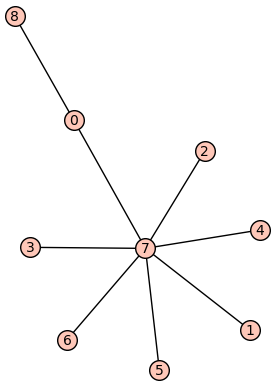

graph6: H???F}?
Obdelujem: n=9, µ=1


/tmp/ipykernel_24691/3385102868.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '45' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, col] = val



=== Rezultati za n=9, µ=1 ===
Best value: 60


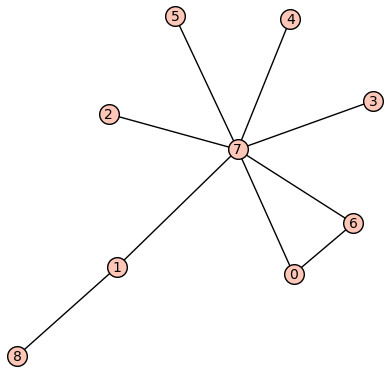

graph6: H??CF|?
Obdelujem: n=9, µ=2


/tmp/ipykernel_24691/3385102868.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '60' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, col] = val



=== Rezultati za n=9, µ=2 ===
Best value: 79


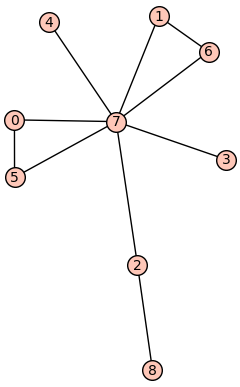

graph6: H?AAF{_
Obdelujem: n=9, µ=3


/tmp/ipykernel_24691/3385102868.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '79' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, col] = val



=== Rezultati za n=9, µ=3 ===
Best value: 102


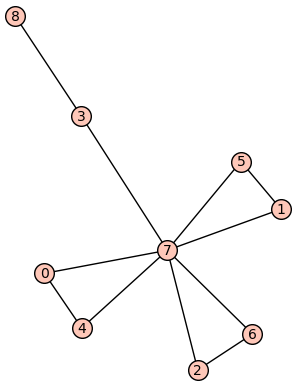

graph6: H?`@F{O
Obdelujem: n=9, µ=4


/tmp/ipykernel_24691/3385102868.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '102' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, col] = val



=== Rezultati za n=9, µ=4 ===
Best value: 146


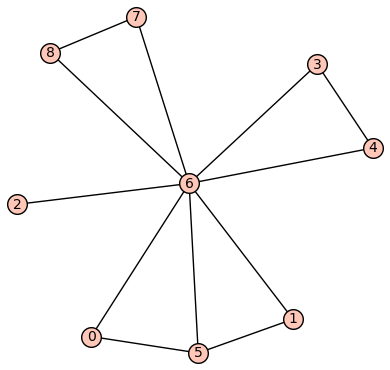

graph6: H?FFwCB
Obdelujem: n=9, µ=5

=== Rezultati za n=9, µ=5 ===
Best value: 206


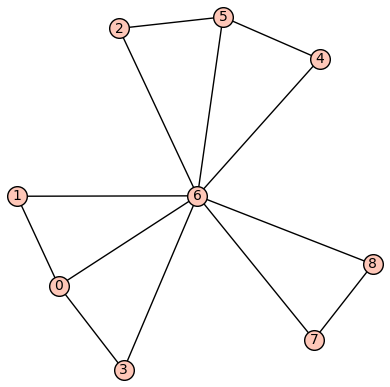

graph6: Hc?nwCB
Obdelujem: n=9, µ=6


/tmp/ipykernel_24691/3385102868.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '206' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, col] = val



=== Rezultati za n=9, µ=6 ===
Best value: 295


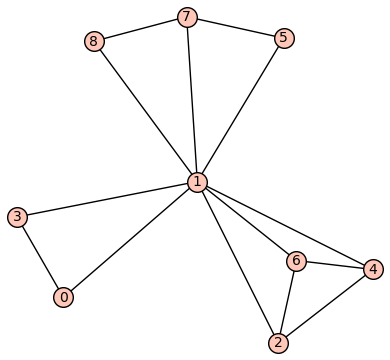

graph6: HmXBQH@
Obdelujem: n=9, µ=7

=== Rezultati za n=9, µ=7 ===
Best value: 423


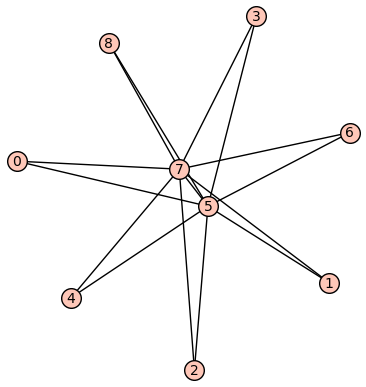

graph6: H?BwN{D
Obdelujem: n=9, µ=8

=== Rezultati za n=9, µ=8 ===
Best value: 634


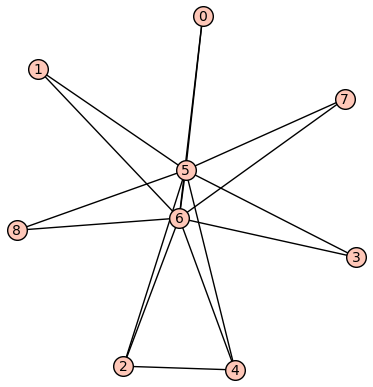

graph6: H?J~wKE
Obdelujem: n=9, µ=9

=== Rezultati za n=9, µ=9 ===
Best value: 949


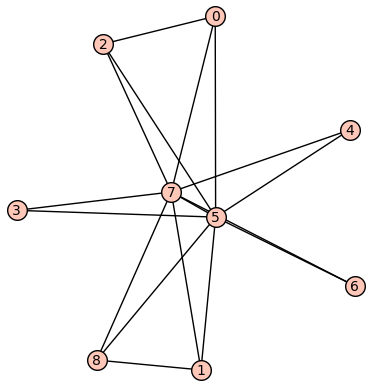

graph6: HOBwN|D
Obdelujem: n=9, µ=10

=== Rezultati za n=9, µ=10 ===
Best value: 1416


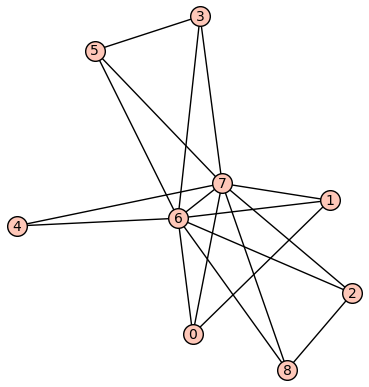

graph6: H_?V~{b
Obdelujem: n=9, µ=11

=== Rezultati za n=9, µ=11 ===
Best value: 2149


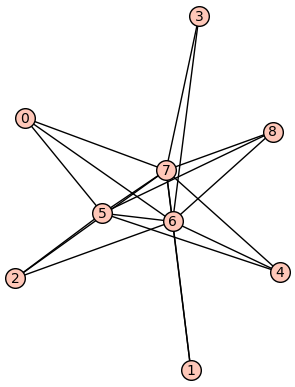

graph6: H?An~{F
Obdelujem: n=9, µ=12

=== Rezultati za n=9, µ=12 ===
Best value: 2948


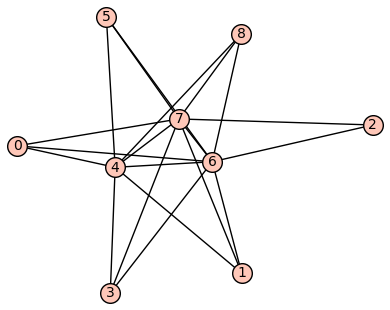

graph6: H?sN~{J
Obdelujem: n=9, µ=13

=== Rezultati za n=9, µ=13 ===
Best value: 3894


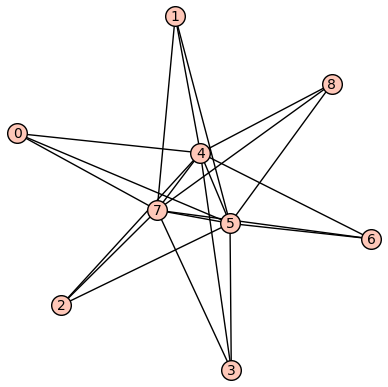

graph6: H?~w^{L
Obdelujem: n=9, µ=14

=== Rezultati za n=9, µ=14 ===
Best value: 6055


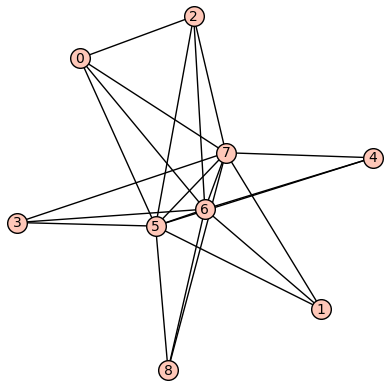

graph6: HOB~~{F
Obdelujem: n=9, µ=15

=== Rezultati za n=9, µ=15 ===
Best value: 10770


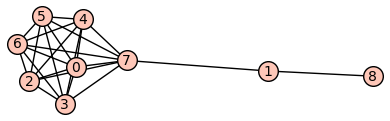

graph6: HTm|~|?
Obdelujem: n=9, µ=16

=== Rezultati za n=9, µ=16 ===
Best value: 14748


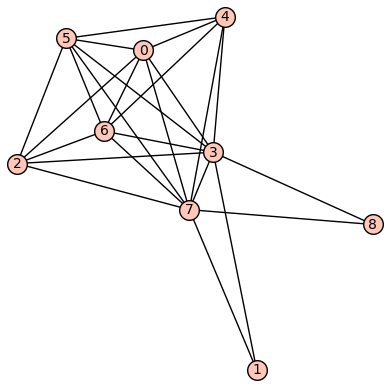

graph6: HVe|~{P
Obdelujem: n=9, µ=17

=== Rezultati za n=9, µ=17 ===
Best value: 19903


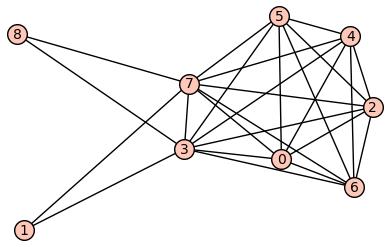

graph6: HVm|~{P
Obdelujem: n=9, µ=18


KeyboardInterrupt: 

In [3]:
import random as pyrandom
from sage.all import *
import pandas as pd

def all_simple_paths(G, start, end, visited=None):
    if visited is None:
        visited = []
    visited = visited + [start]
    if start == end:
        return [visited]
    paths = []
    for nei in G.neighbors(start):
        if nei not in visited:
            newp = all_simple_paths(G, nei, end, visited)
            paths.extend(newp)
    return paths


def subpath_number(G):
    V = G.vertices()
    total = 0
    for i in range(len(V)):
        for j in range(i, len(V)):
            total += len(all_simple_paths(G, V[i], V[j]))
    return total



def save_to_csv(n, mu, graph, score, direction):
    filename = "rezultati_subpath_grafi_enolicni.csv"

    g6 = graph.graph6_string()
    m = graph.size()

    # Če CSV ne obstaja → kreiraj
    if not os.path.exists(filename):
        df = pd.DataFrame(columns=[
            "n", "µ(G)", "m(G)", "subpath_value",
            "graph6_min", "graph6_max"
        ])
        df.to_csv(filename, index=False)

    df = pd.read_csv(filename, encoding="utf-8")

    # Pretvori tipe
    df["n"] = df["n"].astype(int)
    df["µ(G)"] = df["µ(G)"].astype(int)

    n_int = int(n)
    mu_int = int(mu)

    new_row = {
        "n": n_int,
        "µ(G)": mu_int,
        "m(G)": m,
        "subpath_value": score,
        "graph6_min": g6 if direction == "min" else "",
        "graph6_max": g6 if direction == "max" else ""
    }

    # Poišči indeks — tukaj se izognemo vsaki interakciji s SAGE
    matching_indices = df.index[(df["n"] == n_int) & (df["µ(G)"] == mu_int)]

    if len(matching_indices) > 0:
        # matching_indices je Panda Index → PRAVI Python int dobiš tako:
        idx = int(matching_indices.tolist()[0])
        for col, val in new_row.items():
            df.at[idx, col] = val
    else:
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    df.to_csv(filename, index=False)


def mutate_graph(G):
    H = G.copy()

    edges = list(H.edges())
    non_edges = [(u, v) for u in H.vertices()
                 for v in H.vertices()
                 if u < v and not H.has_edge(u, v)]

    if not edges or not non_edges:
        return H

    e_remove = pyrandom.choice(edges)
    H.delete_edge(e_remove)

    e_add = pyrandom.choice(non_edges)
    H.add_edge(e_add)

    if not H.is_connected():
        return G

    return H


def add_one_vertex_and_connect(G_old, direction):
    H = Graph(G_old)

    verts = H.vertices()
    if len(verts) == 0:
        raise ValueError("Graf nima vozlišč — graph6 zapis je pokvarjen ali prazen.")

    new_v = max(verts) + 1
    H.add_vertex(new_v)

    # STOPNJE KOT SLOVAR {vozlišče: stopnja}
    degrees = {v: H.degree(v) for v in H.vertices() if v != new_v}

    if len(degrees) == 0:
        raise ValueError("Graf je imel samo eno vozlišče — ne morem izbrati anchor.")

    if direction == "min":
        anchor = min(degrees, key=degrees.get)
    else:
        anchor = max(degrees, key=degrees.get)

    if anchor == new_v:
        raise ValueError(f"Anchor ({anchor}) = new_v ({new_v}) — nekaj je narobe v grafu.")

    H.add_edge(anchor, new_v)
    return H




def add_one_edge(G_old):
    H = Graph(G_old)

    V = H.vertices()
    for i in range(len(V)):
        for j in range(i+1, len(V)):
            u, v = V[i], V[j]
            if not H.has_edge(u, v):
                H.add_edge(u, v)
                return H

    # če ni nobenega non-edge
    raise ValueError("Graf je že poln — ni več možno dodati ene povezave.")

def load_G(n_val, mu_val, direction):
    df = pd.read_csv("rezultati_subpath_grafi_enolicni.csv", encoding="utf-8")

    df["n"] = df["n"].astype(int)
    df["µ(G)"] = df["µ(G)"].astype(int)

    # Konverzija Sage Integer → Python int
    n_val = int(n_val)
    mu_val = int(mu_val)

    subset = df[df["n"] == n_val]
    if subset.empty:
        raise ValueError(f"Ni vrstic za n={n_val}")

    row = subset[subset["µ(G)"] == mu_val]
    if row.empty:
        raise ValueError(f"Ni vrstice za n={n_val}, µ={mu_val}")

    # KLJUČNO — prisili Python int indeks
    row = row.iloc[int(0)]

    # graph6
    if direction == "min":
        g6 = str(row["graph6_min"]).strip()
    else:
        g6 = str(row["graph6_max"]).strip()

    if g6 == "":
        raise ValueError(f"Prazni graph6 zapis pri n={n_val}, µ={mu_val}")

    return Graph(g6)



def simulated_annealing(n, m, direction,
                        T_start=25.0, T_end=0.001,
                        cooling=0.9995, max_steps=4000,
                        initial_graph=None):

    if initial_graph is not None:
        G = Graph(initial_graph)
    else:
        # fallback = stara logika
        mu = m - n + 1
        if mu >= 1:
            G_old = load_optimal_graph_flexible(n_old=n-1,
                                                mu_desired=mu+1,
                                                direction=direction)
        else:
            G_old = load_optimal_graph_flexible(n_old=n-1,
                                                mu_desired=1,
                                                direction=direction)

        G = expand_graph(G_old, n_new=n, m_target=m, direction=direction)

    best_G = G.copy()
    best_score = subpath_number(G)

    current_G = G.copy()
    current_score = best_score

    T = T_start

    for step in range(max_steps):
        new_G = mutate_graph(current_G)
        new_score = subpath_number(new_G)

        if direction == "min":
            delta = new_score - current_score
        else:
            delta = current_score - new_score

        if delta < 0:
            current_G = new_G
            current_score = new_score
        else:
            if pyrandom.random() < exp(-delta/T):
                current_G = new_G
                current_score = new_score

        improved = ((direction == "min" and current_score < best_score) or
                    (direction == "max" and current_score > best_score))

        if improved:
            best_G = current_G.copy()
            best_score = current_score

        T *= cooling
        if T < T_end:
            break

    return best_G, best_score

def compute_all_for_n9(direction):

    n = 9
    mu_max_prev = 21   # za n=8
    mu_max_n9   = 28   # za n=9

    for mu in range(0, mu_max_n9 + 1):

        print(f"Obdelujem: n=9, µ={mu}")

        if mu <= mu_max_prev:
            # 1. DEL — gradimo iz n=8
            G8 = load_G(8, mu, direction)
            Gstart = add_one_vertex_and_connect(G8, direction)
        else:
            # 2. DEL — gradimo iz prejšnjega optimuma n=9
            Gprev = load_G(9, mu-1, direction)
            Gstart = add_one_edge(Gprev)

        # Pretvori µ → m
        m = mu + n - 1

        best_graph, best_value = simulated_annealing(
            n=n, 
            m=m, 
            direction=direction,
            initial_graph=Gstart
        )

        print(f"\n=== Rezultati za n={n}, µ={mu} ===")
        print("Best value:", best_value)
        best_graph.show()
        print("graph6:", best_graph.graph6_string())

        save_to_csv(n, mu, best_graph, best_value, direction)


# vse tvoje funkcije nad tem …
# …
# …

# === GLAVNI KLIC ===
compute_all_for_n9(direction="min")
